In [60]:
import os
os.chdir('/home/dgotzens/scripts/')

from timedataparser import load_all
from torch.fft import fft,ifft,fftshift,ifftshift
import matplotlib.pyplot as plt
import tools, torch
import numpy as np

loaded data with shape torch.Size([1022, 192, 51])
loaded data with shape torch.Size([1022, 192, 983])
loaded data with shape torch.Size([1022, 192, 9])


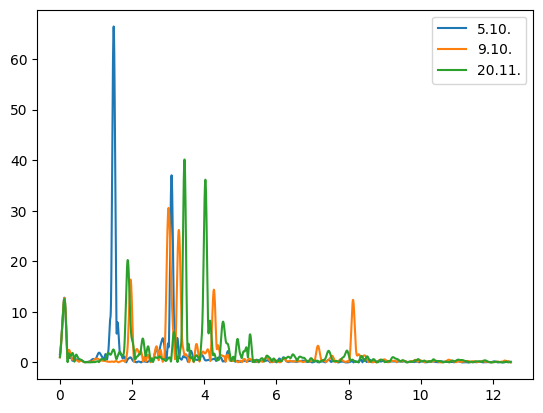

In [61]:
header,_,data,_ = load_all('/home/dgotzens/recording/23-10-05/')
nfft = 2**13
ranges = tools.ranges(header,nfft)
plt.plot(ranges[:nfft//2], tools.rangedata(data[:,0,0])[:nfft//2].abs(), label='5.10.')

header,_,data,_ = load_all('/home/dgotzens/recording/23-10-09/')
nfft = 2**13
ranges = tools.ranges(header,nfft)
plt.plot(ranges[:nfft//2], tools.rangedata(data[:,0,0])[:nfft//2].abs(), label='9.10.')

header,_,data,_ = load_all('/home/dgotzens/recording/23-11-20/')
nfft = 2**13
ranges = tools.ranges(header,nfft)
plt.plot(ranges[:nfft//2], tools.rangedata(data[:,0,0])[:nfft//2].abs(), label='20.11.')
plt.legend()
plt.show()

# Backprojection

In [62]:
header,time,data,_,feparams = load_all('/home/dgotzens/recording/23-11-20/', loadfeparams=True)
M,K,L = data.shape
X,Y,Z = (256,3,256)
I = X*Y*Z
c0 = 299_792_458
β = feparams['RampSlope']
fs = header['SampleRate']

rmax = 5
x = torch.linspace(-rmax/2, rmax/2, X)[:,None,None].expand((X,Y,Z))
y = torch.linspace(-0.1*rmax, 0.1*rmax, Y)[None,:,None].expand((X,Y,Z))
z = torch.linspace(0,rmax,Z)[None,None,:].expand((X,Y,Z))
print(2*torch.pi*β*(2*3.74/c0))
print(2*torch.pi*β*(2*3.74/c0)/fs)


loaded data with shape torch.Size([1022, 192, 9])
10338961.27150164
0.4699527850682564


Target at $r_0=3.5m$
 
Ramp slope $\beta = 66GHz/s$
 
Sample rate $f_s = 22MHz$
 
$\Rightarrow x_0 (t) \sim e^{-j2\pi \beta \frac{2r_0}{c_0} t} = e^{-j10.3MHz \cdot t}$
 
$\Rightarrow x_0 (t=mT_s) \sim e^{-j 0.47 m }$



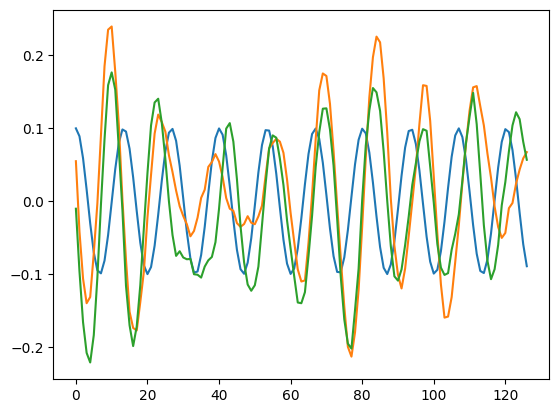

3.74833399432701

In [63]:
plt.plot((0.47*torch.arange(0,M//8)).cos()*0.1)
plt.plot(data[:M//8,0,0].real)
plt.plot(data[:M//8,1,0].real)
plt.show()
6.28*9/120 * c0 * fs /(4*torch.pi*β)

$2\pi \beta \frac{2r_0}{c_0f_s} \approx 0.471$
$\Rightarrow r_0 = 0.471 \frac{c_0f_s}{4 \pi \beta} = 3.748m$

In [64]:
# assume constant antenna gain
g = torch.ones((K,X,Y,Z))

# calculate runtimes
dist = torch.empty((K,X,Y,Z))
for k in range(K):
    dist[k,...] =  ((feparams['txPosX'][k] - x)**2 + abs(feparams['txPosY'][k] - y)**2 + z**2).sqrt()\
                 + ((feparams['rxPosX'][k] - x)**2 + abs(feparams['rxPosY'][k] - y)**2 + z**2).sqrt()

False


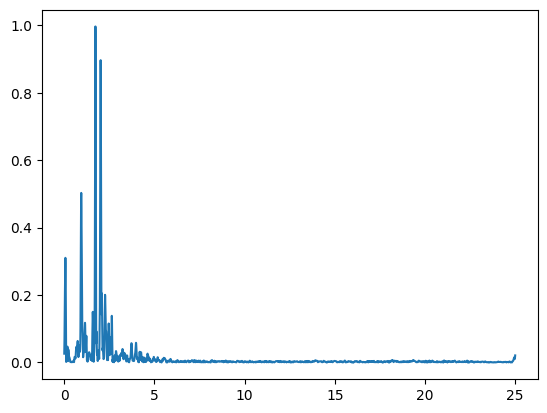

In [65]:
# calibrate data
nfft = 2**13
rangedata = tools.rangedata(data, N=nfft)
M,K,L = rangedata.shape
search_idx = torch.tensor([m for m,r in enumerate(tools.ranges(header, nfft)) if 3<r*2<3.8])
m_refl = tools.reflidx(rangedata.mean(1),search_idx)

calib_len_min = 4
weights = torch.zeros(K, dtype=torch.cfloat)
for l in range(calib_len_min):
	weights += rangedata[m_refl[l],:,l] / calib_len_min
weights = weights.unsqueeze(-1)
print(0 in weights)
calibrated = rangedata/weights
# plt.plot(tools.ranges(header,nfft)[:2000], rangedata[:2000,0,0].abs())
plt.plot(tools.ranges(header,nfft), calibrated[:,0,0].abs())
plt.show()

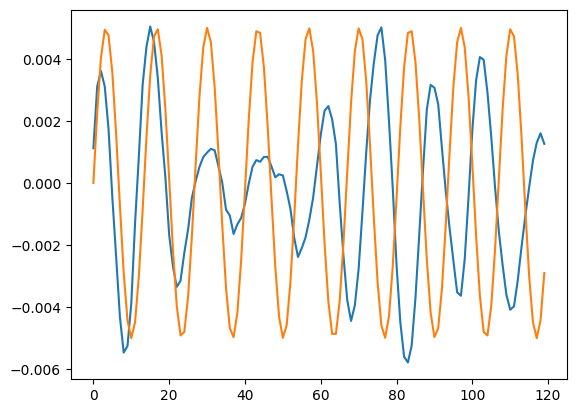

In [79]:
# process data
result = torch.zeros((X,Y,Z), dtype=torch.cfloat).flatten()
window = torch.hann_window(nfft)
calibrated_td = data/weights
plt.plot(calibrated_td[:120,0,0].imag)
plt.plot((0.47*torch.arange(0,120)).sin()*0.005)
plt.show()


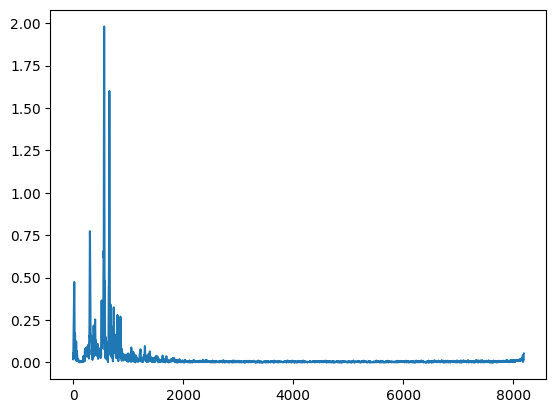

In [67]:
inner_ifft = fft(calibrated_td[:,:,0], n=nfft, dim=0)
# inner_ifft = fftshift(fft(ifftshift(data[:,:,0]), n=nfft, dim=0))
plt.plot(inner_ifft[:,0].abs())
plt.show()
index = (nfft *β*dist/(c0 *fs)).long().clamp(0,inner_ifft.shape[0]).flatten(1)
# plt.plot(index.unflatten(1,(X,Y,Z))[:,5,5,256])
plt.show()

In [107]:
x = torch.zeros(1024)
x.repeat((-1,3,3)).shape

RuntimeError: Trying to create tensor with negative dimension -1: [-1, 3, 3072]

In [134]:
from math import log2, ceil
ldM = ceil(log2(M))
result = torch.zeros((X,Y,Z), dtype=torch.cfloat)
for k in range(K):
    print(k)
    subres = torch.zeros((X,Y,Z,2**ldM), dtype=torch.cfloat)
    subres[...,:M] = data[:,k,0]
    exp = torch.exp(-2j*torch.pi*β*dist[k,...]/(c0*fs)).unsqueeze(-1)
    idx = range(1,2**ldM,2)
    for n in range(ldM):
        subres[...,idx] *= exp
        exp **= 2
        idx = idx[1::2]
    result += subres.sum(dim=-1)

# for m in range(int(log2))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


IndexError: too many indices for tensor of dimension 1

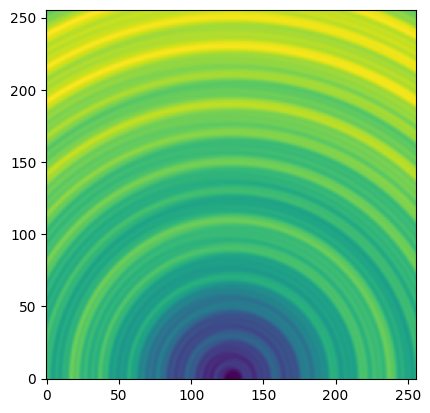

In [135]:
result /= M*weights.abs().sum(dim=0)

plt.imshow(result[:,Y//2,:].real.T, origin='lower')
# plt.imshow(result[:,Y//2,:].abs().T, origin='lower')
plt.xticks(range(0,X,X//6), [round(float(x[i,0,0]),1) for i in range(0,X,X//6)])
plt.yticks(range(0,Z,Z//6), [round(float(z[0,0,i]),1) for i in range(0,Z,Z//6)])
plt.xlabel('x[m]')
plt.ylabel('z[m]')
plt.colorbar(label='intensity')
plt.title('Backprojection')
plt.show()

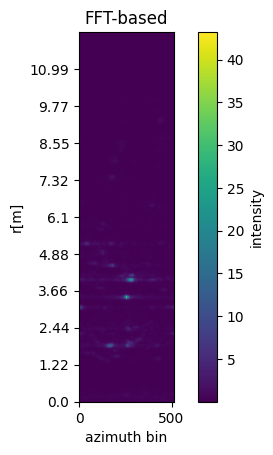

In [70]:
ula_idx = tools.ula_idx(header)
window = torch.hann_window(len(ula_idx))
img = fftshift(fft(ifftshift(window*calibrated[:,ula_idx,l]),n=512)).abs()
plt.imshow(img[:2000], origin='lower')
plt.colorbar(label='intensity')
plt.title('FFT-based')
plt.xlabel('azimuth bin')
plt.yticks(range(0,2000,200),[round(tools.ranges(header,nfft)[m]*2,2) for m in range(0,2000,200)])
plt.ylabel('r[m]')
plt.show()